# Running Order Scheduling

In this section, we will detail the running order scheduling in `BrainPy`, and tell you how to customize the running order of objects in a network. 

In [1]:
import brainpy as bp

import warnings
warnings.filterwarnings("ignore")

## Step function

In BrainPy, the basic concept for neurodynamics simulation is the `step function`. For example, in a customized `brainpy.NeuGroup`, 

In [2]:
class HH(bp.NeuGroup):
    target_backend = 'numpy'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        super(HH, self).__init__(size=size, **kwargs)

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.m = bp.ops.ones(self.num) * 0.5
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num)
        self.input = bp.ops.zeros(self.num)

    @bp.odeint(method='exponential_euler')
    def integral(self, V, m, h, n, t, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (self.gNa * m ** 3 * h) * (V - self.ENa)
        I_K = (self.gK * n ** 4) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

        return dVdt, dmdt, dhdt, dndt

    def update(self, _t, _i, _dt):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

three step functions are included:

- `update` step function (explicitly defined by users)
- `monitor` step function (implicitly generated by BrainPy if users require monitors when intializing `HH` model: `group = HH(..., monitors=['V', ...])`)
- `input` step function (implicitly generated by BrainPy if users give inputs: `group.run(..., inputs=('input', 10.))`)

We can inspect this by:

In [3]:
group1 = HH(1, monitors=['V', 'input'])

hh_schedule = tuple(group1.schedule())
hh_schedule

('input', 'update', 'monitor')

Later, BrainPy will update the step functions by the running order of `hh_schedule`:

In [4]:
group1.build(duration=100, inputs=('input', 10.), show_code=True)

The input to a new key "input" in <__main__.HH object at 0x0000022CD3844580>.
def input_step(_i):
  NG1.input += NG1._input_data_of_input
{'NG1': <__main__.HH object at 0x0000022CD3844580>}

def monitor_step(_i, _t):
  NG1.mon.V[_i] = NG1.V
  NG1.mon.V_t[_i] = _t
  NG1.mon.input[_i] = NG1.input
  NG1.mon.input_t[_i] = _t
{'NG1': <__main__.HH object at 0x0000022CD3844580>,
 'ops': <module 'brainpy.backend.ops' from '../..\\brainpy\\backend\\ops\\__init__.py'>}

def run_func(_t, _i, _dt):
  NG1.input_step(_i)
  NG1.update(_t, _i, _dt)
  NG1.monitor_step(_i, _t)
{'NG1': <__main__.HH object at 0x0000022CD3844580>}



<function run_func(_t, _i, _dt)>

As you can see, in the final `run_func(_t, _i, _dt)`, the running order of step functions is in line with the `hh_schedule`.

## Customize `schedule()`

Fortunately, BrainPy allows users to customize the running schedule. 

### Customize `schedule()` in a brain object

Let's take the above `HH` class as the example to illustrate how to customize the running order in a single brain object:

In [5]:
class HH2(bp.NeuGroup):
    target_backend = 'numpy'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        super(HH2, self).__init__(size=size, **kwargs)

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.m = bp.ops.ones(self.num) * 0.5
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num)
        self.input = bp.ops.zeros(self.num)

    @bp.odeint(method='exponential_euler')
    def integral(self, V, m, h, n, t, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
        I_K = (self.gK * n ** 4.0) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

        return dVdt, dmdt, dhdt, dndt

    def update(self, _t, _i, _dt):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

    def schedule(self):
        return ('monitor',) + tuple(self.steps.keys()) + ('input',)

Here, we define `HH2` class. What's different from the above `HH` model is that the customized `schedule()` function makes the `monitor` function and the user-defined `steps` functions run first, then run the `input` function. 

In [6]:
group2 = HH2(1, monitors=['V', 'input'])

group2.schedule()

('monitor', 'update', 'input')

The advantage of such scheduling arrangement is that users can monitor the total synaptic inputs at each time step:

In [7]:
import numpy as np

duration = 100
random_inputs = np.random.random(int(duration / bp.backend.get_dt())) * 10.

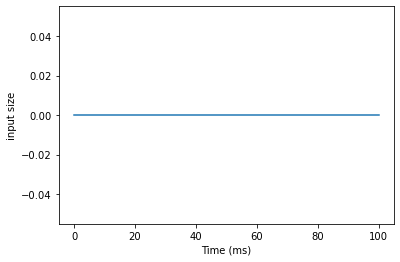

In [8]:
group1.run(duration, inputs=('input', random_inputs))

bp.visualize.line_plot(group1.mon.input_t, group1.mon.input,
                       ylabel='input size', show=True)

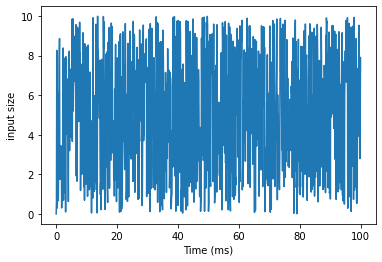

In [9]:
group2.run(duration, inputs=('input', random_inputs))

bp.visualize.line_plot(group2.mon.input_t, group2.mon.input,
                       ylabel='input size', show=True)

This is because in the original `HH` class, the `self.input` variable is reset to 0 in the `update` function before calling the `monitor_step` function.

### Customize `schedule()` in a network

Similarly, the running order scheduling for multiple brain objects in a network can also be customized. Let's illustrate this by a COBA E/I balance network.

In [10]:
bp.backend.set('numba')

# Parameters for the neurons
num_exc, num_inh = 3200, 800
tau = 20  # ms
Vt = -50  # mV
Vr = -60  # mV
El = -60  # mV
ref_time = 5.0  # refractory time, ms

In [11]:
class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    @staticmethod
    @bp.odeint(method='exponential_euler')
    def int_V(V, t, Iexc):
        dV = (Iexc + El - V) / tau
        return dV

    def __init__(self, size, **kwargs):
        super(LIF, self).__init__(
            size=size, steps=[self.update, self.threshold, self.reset], **kwargs)

        # variables
        self.V = bp.ops.zeros(self.num)
        self.input = bp.ops.zeros(self.num)
        self.spike = bp.ops.zeros(self.num, dtype=bool)
        self.t_last_spike = bp.ops.ones(self.num) * -1e7

    def update(self, _t):
        # update the membrane potential
        for i in range(self.num):
            if (_t - self.t_last_spike[i]) > ref_time:
                self.V[i] = self.int_V(self.V[i], _t, self.input[i])

    def threshold(self):
        # judge whether the neuron potential reach the spike threshold
        for i in range(self.num):
            self.spike[i] = self.V[i] >= Vt

    def reset(self, _t):
        # reset the neuron potential.
        for i in range(self.num):
            if self.spike[i]:
                self.V[i] = Vr
                self.t_last_spike[i] = _t
            self.input[i] = 20.

In [12]:
# Parameters for the synapses
tau_exc = 5  # ms
tau_inh = 10  # ms
E_exc = 0.  # mV
E_inh = -80.  # mV
delta_exc = 0.6  # excitatory synaptic weight
delta_inh = 6.7  # inhibitory synaptic weight

In [13]:
class Syn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    @staticmethod
    @bp.odeint(method='exponential_euler')
    def int_g(g, t, tau):
        dg = - g / tau
        return dg

    def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
        # parameters
        self.tau = tau
        self.weight = weight
        self.E = E

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_slice, self.post_ids = self.conn.requires('pre_slice', 'post_ids')

        # variables
        self.g = bp.ops.zeros(post.num)

        super(Syn, self).__init__(pre=pre, post=post,
                                  steps=[self.update, self.output],
                                  **kwargs)

    def update(self, _t):
        self.g = self.int_g(self.g, _t, self.tau)
        # p1: update
        for pre_i in range(self.pre.num):
            if self.pre.spike[pre_i]:
                start, end = self.pre_slice[pre_i]
                for post_i in self.post_ids[start: end]:
                    self.g[post_i] += self.weight

    def output(self):
        # p2: output
        self.post.input += self.g * (self.E - self.post.V)

In [14]:
def run_network(net_model):
    from pprint import pprint
    
    E = LIF(num_exc, monitors=['spike'], name='E')
    E.V = np.random.randn(num_exc) * 5. + Vr

    I = LIF(num_inh, monitors=['spike'], name='I')
    I.V = np.random.randn(num_inh) * 5. + Vr

    E2E = Syn(pre=E, post=E, conn=bp.connect.FixedProb(0.02),
              tau=tau_exc, weight=delta_exc, E=E_exc, name='E2E')
    E2I = Syn(pre=E, post=I, conn=bp.connect.FixedProb(0.02),
              tau=tau_exc, weight=delta_exc, E=E_exc, name='E2I')
    I2E = Syn(pre=I, post=E, conn=bp.connect.FixedProb(0.02),
              tau=tau_inh, weight=delta_inh, E=E_inh, name='I2E')
    I2I = Syn(pre=I, post=I, conn=bp.connect.FixedProb(0.02),
              tau=tau_inh, weight=delta_inh, E=E_inh, name='I2I')

    net = net_model(E, I, E2E, E2I, I2E, I2I)
    
    print(f'The network schedule is: ')
    pprint(list(net.schedule()))
    
    t = net.run(100.)
    
    print('\n\nThe running result is:')
    fig, gs = bp.visualize.get_figure(row_num=5, col_num=1, row_len=1, col_len=10)
    fig.add_subplot(gs[:4, 0])
    bp.visualize.raster_plot(E.mon.spike_t, E.mon.spike, ylabel='E Group', xlabel='')
    fig.add_subplot(gs[4, 0])
    bp.visualize.raster_plot(I.mon.spike_t, I.mon.spike, ylabel='I Group', show=True)

The default scheduling in a network is the serial running of the brain objects. The code for schedule generation is like this:

In [15]:
class DefaultNetwork(bp.Network):
    def schedule(self):
        for node in self.all_nodes.values():
            for key in node.schedule():
                yield f'{node.name}.{key}'

The network schedule is: 
['E.input',
 'E.update',
 'E.threshold',
 'E.reset',
 'E.monitor',
 'I.input',
 'I.update',
 'I.threshold',
 'I.reset',
 'I.monitor',
 'E2E.input',
 'E2E.update',
 'E2E.output',
 'E2E.monitor',
 'E2I.input',
 'E2I.update',
 'E2I.output',
 'E2I.monitor',
 'I2E.input',
 'I2E.update',
 'I2E.output',
 'I2E.monitor',
 'I2I.input',
 'I2I.update',
 'I2I.output',
 'I2I.monitor']


The running result is:


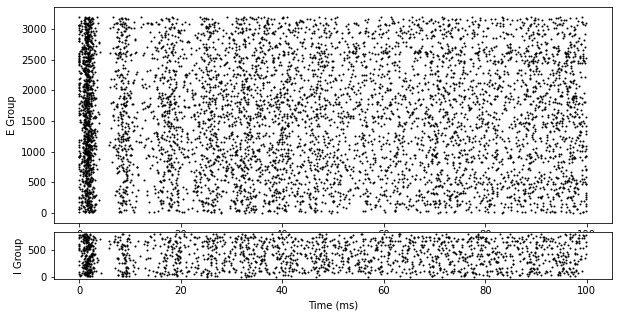

In [16]:
run_network(DefaultNetwork)

In the next, we will define a network model in which all the `input` functions run first, then run the synaptic step functions (because the synapses will output the values to neuron groups), next we run the neuronal step functions, finally we monitor the neural and synaptic variables.

In [17]:
class CustomizedNetwork(bp.Network):
    def schedule(self):
        
        # run input functions
        for node in self.all_nodes.values():  # self.all_nodes is a dict with the 
                                              # format of {"node_name": node}
            yield f'{node.name}.input'
            
        # run synpatic step functions
        for node in self.all_nodes.values():
            if isinstance(node, bp.SynConn):
                for key in node.steps.keys(): # node.steps is a dict with the 
                                              # format of {"step_name": step}
                    yield f'{node.name}.{key}'
                    
        # run neural model step functions
        for node in self.all_nodes.values():
            if isinstance(node, bp.NeuGroup):
                for key in node.steps.keys(): # node.steps is a dict with the 
                                              # format of {"step_name": step}
                    yield f'{node.name}.{key}'
                    
        # run the monitor functions
        for node in self.all_nodes.values(): 
            yield f'{node.name}.monitor'

The network schedule is: 
['E.input',
 'I.input',
 'E2E.input',
 'E2I.input',
 'I2E.input',
 'I2I.input',
 'E2E.update',
 'E2E.output',
 'E2I.update',
 'E2I.output',
 'I2E.update',
 'I2E.output',
 'I2I.update',
 'I2I.output',
 'E.update',
 'E.threshold',
 'E.reset',
 'I.update',
 'I.threshold',
 'I.reset',
 'E.monitor',
 'I.monitor',
 'E2E.monitor',
 'E2I.monitor',
 'I2E.monitor',
 'I2I.monitor']


The running result is:


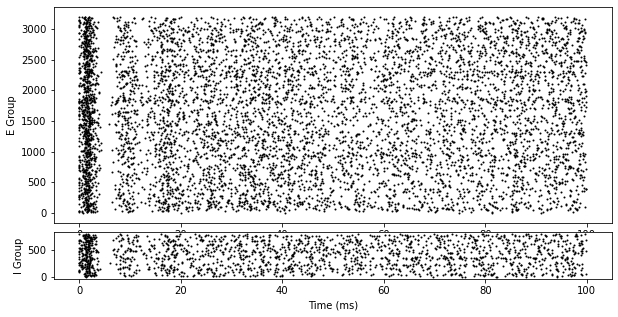

In [18]:
run_network(CustomizedNetwork)

## Decorator `@every`

In default, step functions in BrainPy will be updated at every `dt`. However, in a real scenario, some step functions may have a updating period different from `dt`, for example, rest a variable at every `10 ms`. Therefore, BrainPy provides another useful scheduling decorator `@every(time)`, where `time` can be an int/float (denoting to update with a constant period), or can be a bool function (denoting to update with a varied period).

We illustrate this by also using the HH neuron model:

In [19]:
bp.backend.set('numpy')

In [20]:
class HH3(bp.NeuGroup):
    target_backend = 'numpy'

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        super(HH3, self).__init__(size=size, **kwargs)

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.m = bp.ops.ones(self.num) * 0.5
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num)
        self.input = bp.ops.ones(self.num) * 10.

    @bp.odeint(method='exponential_euler')
    def integral(self, V, m, h, n, t, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
        I_K = (self.gK * n ** 4.0) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

        return dVdt, dmdt, dhdt, dndt

    @bp.every(time=lambda: np.random.random() < 0.5)
    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n

In the `HH3` model, at the top of `update()` function, the decorator `every()` receives a bool function. It represents at each `dt`, if the bool function returns "True", the corresponding step function will be updated, if "False", the step function will not be called. Therefore, `@bp.every(time=lambda: np.random.random() < 0.5)` denotes there is a 50% probability to run the `update()` function at each time step `dt`. 

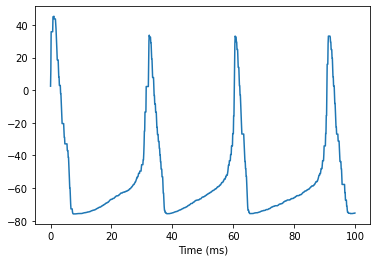

In [21]:
group3 = HH3(1, monitors=['V'])

group3.run(100.)

bp.visualize.line_plot(group3.mon.V_t, group3.mon.V, show=True)

As you will see, the monitors will get the same values (variables not be updated) at the nearest neighborhood time points.

In [22]:
group3.mon.V[:20]

array([[ 2.44966378],
       [12.6364925 ],
       [35.82151319],
       [35.82151319],
       [35.82151319],
       [35.82151319],
       [35.82151319],
       [35.82151319],
       [45.01057186],
       [45.01057186],
       [45.01057186],
       [45.32911768],
       [43.67693542],
       [43.67693542],
       [43.67693542],
       [43.67693542],
       [43.67693542],
       [41.04038136],
       [37.57836768],
       [33.4323443 ]])

---

**Author**:

- Chaoming Wang
- Email: adaduo@outlook.com
- Date: 2021.05.25

---